In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client

In [ ]:
def get_crypto_data(symbol, start_date, interval):
    client = Client() 
    
    try:
        klines = client.get_historical_klines(symbol, interval, start_date)
        
        # Tworzenie DataFrame zgodnie z dokumentacją Binance
        df = pd.DataFrame(klines, columns=[
            'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close time', 'Quote asset volume', 'Number of trades',
            'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
        ])
        
        # Formatowanie czasu i typów danych
        df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
        df.set_index('Open time', inplace=True)
        
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        df[numeric_cols] = df[numeric_cols].astype(float)
        
        return df[['Close', 'Volume']]
    except Exception as e:
        print(f"Wystąpił błąd: {e}")
        return None

In [ ]:
SYMBOL = 'BTCUSDT' 
START_DATE = '1 Jan, 2018'
INTERVAL = Client.KLINE_INTERVAL_1DAY

df = get_crypto_data(SYMBOL, START_DATE, INTERVAL)

In [ ]:
if df is not None:
    # Obliczanie średnich kroczących
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    
    # Usunięcie NaN (pierwsze 200 dni nie ma pełnej średniej)
    df.dropna(inplace=True)


In [ ]:
initial_capital = 10000  # Startujemy z 10k USD 
capital = initial_capital
in_position = False
position_size = 0  
trades = []

In [ ]:
for i in range(1, len(df)):
    prev = df.iloc[i-1]
    curr = df.iloc[i]
    
    # Definicja sygnałów
    # Złoty Krzyż (Golden Cross): 50 przecina 200 od dołu
    golden_cross = (prev['SMA_50'] < prev['SMA_200']) and (curr['SMA_50'] > curr['SMA_200'])
    
    # Krzyż Śmierci (Death Cross): 50 przecina 200 od góry
    death_cross = (prev['SMA_50'] > prev['SMA_200']) and (curr['SMA_50'] < curr['SMA_200'])
    
    date = df.index[i]
    price = curr['Close']
    
    # Kupno
    if golden_cross and not in_position:
        amount_to_buy = capital / price
        position_size = amount_to_buy
        capital = 0
        in_position = True
        trades.append({'date': date, 'type': 'BUY', 'price': price})
        print(f"KUPNO: {date.date()} po cenie ${price:.2f}")
        
    # Sprzedaż
    elif death_cross and in_position:
        capital = position_size * price
        position_size = 0
        in_position = False
        trades.append({'date': date, 'type': 'SELL', 'price': price})
        print(f"SPRZEDAŻ: {date.date()} po cenie ${price:.2f}")

KUPNO: 2019-04-24 po cenie $5415.00
SPRZEDAŻ: 2019-10-26 po cenie $9230.00
KUPNO: 2020-02-18 po cenie $10164.71
SPRZEDAŻ: 2020-03-25 po cenie $6677.43
KUPNO: 2020-05-21 po cenie $9068.65
SPRZEDAŻ: 2021-06-19 po cenie $35483.72
KUPNO: 2021-09-15 po cenie $48121.41
SPRZEDAŻ: 2022-01-14 po cenie $43059.96
KUPNO: 2023-02-07 po cenie $23240.46
SPRZEDAŻ: 2023-09-12 po cenie $25840.10
KUPNO: 2023-10-30 po cenie $34474.73
SPRZEDAŻ: 2024-08-10 po cenie $60923.51
KUPNO: 2024-10-28 po cenie $69962.21
SPRZEDAŻ: 2025-04-07 po cenie $79163.24
KUPNO: 2025-05-22 po cenie $111696.21
SPRZEDAŻ: 2025-11-16 po cenie $94261.44


In [ ]:
final_value = capital if not in_position else position_size * df.iloc[-1]['Close']
total_return = ((final_value - initial_capital) / initial_capital) * 100

print(f"Kapitał początkowy: ${initial_capital}")
print(f"Kapitał końcowy:    ${final_value:.2f}")
print(f"Zwrot całkowity:    {total_return:.2f}%")

Kapitał początkowy: $10000
Kapitał końcowy:    $73557.77
Zwrot całkowity:    635.58%


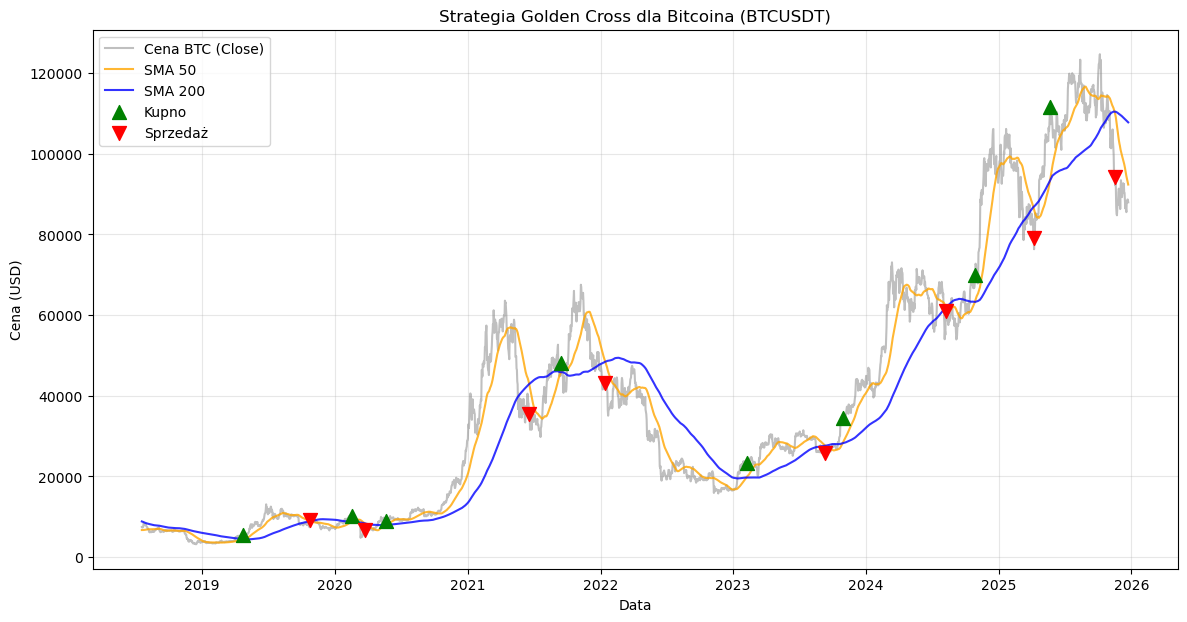

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Cena BTC (Close)', alpha=0.5, color='gray')
plt.plot(df.index, df['SMA_50'], label='SMA 50', color='orange', alpha=0.8)
plt.plot(df.index, df['SMA_200'], label='SMA 200', color='blue', alpha=0.8)

trades_df = pd.DataFrame(trades)
if not trades_df.empty:
    buys = trades_df[trades_df['type'] == 'BUY']
    sells = trades_df[trades_df['type'] == 'SELL']
    
    plt.scatter(buys['date'], buys['price'], marker='^', color='green', s=100, label='Kupno', zorder=5)
    plt.scatter(sells['date'], sells['price'], marker='v', color='red', s=100, label='Sprzedaż', zorder=5)

plt.title(f'Strategia Golden Cross dla Bitcoina (BTCUSDT)')
plt.xlabel('Data')
plt.ylabel('Cena (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()